In [22]:
import os
import numpy as np
import random
import torch
from argparse import Namespace
from collections import OrderedDict
import dataloaders
from torch.utils.data import DataLoader
import learners
from typing import Dict, List, Any


class Trainer:
    def __init__(
        self, args: Namespace, seed: int, metric_keys: List[str], save_keys: List[str]
    ) -> None:
        # process inputs
        self.seed: int = seed
        self.metric_keys: List[str] = metric_keys
        self.save_keys: List[str] = save_keys
        self.log_dir: str = args.log_dir
        self.batch_size: int = args.batch_size
        self.workers: int = args.workers

        # model load directory
        self.model_top_dir: str = args.log_dir

        # select dataset
        self.grayscale_vis = False
        self.top_k = 1
        if args.dataset == "CIFAR10":
            Dataset = dataloaders.ILCIFAR10
            num_classes = 10
            self.dataset_size: list[int] = [32, 32, 3]
        elif args.dataset == "CIFAR100":
            Dataset = dataloaders.ILCIFAR100
            num_classes = 100
            self.dataset_size: list[int] = [32, 32, 3]
        elif args.dataset == "ImageNet_R":
            Dataset = dataloaders.ILImageNetR
            num_classes = 200
            self.dataset_size: list[int] = [224, 224, 3]
            self.top_k = 1
        else:
            raise ValueError("Dataset not implemented!")

        # upper bound flag
        if args.upper_bound_flag:
            args.other_split_size = num_classes
            args.first_split_size = num_classes

        # load tasks
        class_order: List[int] = np.arange(num_classes).tolist()
        class_order_logits: List[int] = np.arange(num_classes).tolist()
        if self.seed > 0 and args.rand_split:
            print("=============================================")
            print("Shuffling....")
            print("pre-shuffle:" + str(class_order))
            random.seed(self.seed)
            random.shuffle(class_order)
            print("post-shuffle:" + str(class_order))
            print("=============================================")
        self.tasks: List[List[int]] = []
        self.tasks_logits: List[List[int]] = []
        # p: the number of seen classes
        p = 0
        while p < num_classes and (
            args.max_task == -1 or len(self.tasks) < args.max_task
        ):
            inc: int = args.other_split_size if p > 0 else args.first_split_size
            self.tasks.append(class_order[p: p + inc])
            self.tasks_logits.append(class_order_logits[p: p + inc])
            p += inc
        self.num_tasks: int = len(self.tasks)
        self.task_names: List[str] = [str(i + 1)
                                      for i in range(self.num_tasks)]

        # number of tasks to perform
        if args.max_task > 0:
            self.max_task = min(args.max_task, len(self.task_names))
        else:
            self.max_task = len(self.task_names)

        # datasets and dataloaders
        if args.model_name.startswith("vit"):
            resize_imnet = True
        else:
            resize_imnet = False
        train_transform = dataloaders.utils.get_transform(
            dataset=args.dataset,
            phase="train",
            aug=args.train_aug,
            resize_imnet=resize_imnet,
        )
        test_transform = dataloaders.utils.get_transform(
            dataset=args.dataset,
            phase="test",
            aug=args.train_aug,
            resize_imnet=resize_imnet,
        )
        self.train_dataset = Dataset(
            args.dataroot,
            train=True,
            lab=True,
            tasks=self.tasks,
            download_flag=True,
            transform=train_transform,
            seed=self.seed,
            rand_split=args.rand_split,
            validation=args.validation,
        )
        self.test_dataset = Dataset(
            args.dataroot,
            train=False,
            tasks=self.tasks,
            download_flag=False,
            transform=test_transform,
            seed=self.seed,
            rand_split=args.rand_split,
            validation=args.validation,
        )

        # for oracle
        self.oracle_flag: bool = args.oracle_flag
        self.add_dim = 0

        # Prepare the self.learner (model)
        self.learner_config: Dict[str, Any] = {
            "num_classes": num_classes,
            "lr": args.lr,
            "debug_mode": args.debug_mode == 1,
            "momentum": args.momentum,
            "weight_decay": args.weight_decay,
            "schedule": args.schedule,
            "schedule_type": args.schedule_type,
            "model_type": args.model_type,
            "model_name": args.model_name,
            "optimizer": args.optimizer,
            "gpuid": args.gpuid,
            "memory": args.memory,
            "temp": args.temp,
            "out_dim": num_classes,
            "overwrite": args.overwrite == 1,
            "DW": args.DW,
            "batch_size": args.batch_size,
            "upper_bound_flag": args.upper_bound_flag,
            "tasks": self.tasks_logits,
            "top_k": self.top_k,
            "prompt_param": [self.num_tasks, args.prompt_param],
        }
        self.learner_type: str = args.learner_type
        self.learner_name: str = args.learner_name
        print(learners.__dict__[self.learner_type].__dict__)
        self.learner = learners.__dict__[self.learner_type].__dict__[self.learner_name](
            self.learner_config
        )

In [23]:
from torch.nn import functional as F
def compute_sim(hints, pmts):
    """
    Args:
        hints: [batch_size, nb_pmt, dim]
        pmts: [nb_pmt, pmt_len, dim]
    
    Returns:
        sim: [batch_size, nb_pmt]
    """
    proj_mat = torch.einsum("pij,pjk -> pik", pmts.permute(0, 2, 1), pmts)
    hint_proj = torch.einsum("bpd,pdd->bpd", hints, proj_mat)
    hint_proj = F.normalize(hint_proj, dim=-1, p=2)
    hints = F.normalize(hints, dim=-1, p=2)
    sim = torch.einsum("bpd,bpd->bp", hint_proj, hints)
    return sim

hints = torch.randn(32, 20, 768)
pmts = torch.randn(20, 8, 768)
compute_sim(hints, pmts).shape


torch.Size([32, 20])

In [24]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
import os
import sys
import argparse
from argparse import Namespace

import torch
import torch.backends.cuda
import torch.backends.cudnn
import numpy as np
import yaml
import random
from typing import Dict, Any, List, Union, Sequence


def set_random_seed(seed=1) -> None:
    """Set random seed and cuda backen for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def create_args():
    # This function prepares the variables shared across demo.py
    parser = argparse.ArgumentParser()

    # Standard Args
    parser.add_argument(
        "--gpuid",
        nargs="+",
        type=int,
        default=[0],
        help="The list of gpuid, ex:--gpuid 3 1. Negative value means cpu-only",
    )
    parser.add_argument(
        "--log_dir",
        type=str,
        default="outputs/out",
        help="Save experiments results in dir for future plotting!",
    )
    parser.add_argument(
        "--learner_type",
        type=str,
        default="default",
        help="The type (filename) of learner",
    )
    parser.add_argument(
        "--learner_name", type=str, default="NormalNN", help="The class name of learner"
    )
    parser.add_argument(
        "--debug_mode",
        type=int,
        default=0,
        metavar="N",
        help="activate learner specific settings for debug_mode",
    )
    parser.add_argument(
        "--repeat", type=int, default=1, help="Repeat the experiment N times"
    )
    parser.add_argument(
        "--overwrite",
        type=int,
        default=0,
        metavar="N",
        help="Train regardless of whether saved model exists",
    )

    # CL Args
    parser.add_argument(
        "--oracle_flag",
        default=False,
        action="store_true",
        help="Upper bound for oracle",
    )
    parser.add_argument(
        "--upper_bound_flag", default=False, action="store_true", help="Upper bound"
    )
    parser.add_argument(
        "--memory", type=int, default=0, help="size of memory for replay"
    )
    parser.add_argument(
        "--temp",
        type=float,
        default=2.0,
        dest="temp",
        help="temperature for distillation",
    )
    parser.add_argument(
        "--DW", default=False, action="store_true", help="dataset balancing"
    )
    parser.add_argument(
        "--prompt_param",
        nargs="+",
        type=float,
        default=[1, 1, 1],
        help="e prompt pool size; \
                            e prompt length, g prompt length; \
                                strength of ortho penalty",
    )

    # Config Arg
    parser.add_argument(
        "--config",
        type=str,
        default="configs/config.yaml",
        help="yaml experiment config input",
    )

    return parser


def get_args(argv) -> Namespace:
    parser = create_args()
    args: Namespace = parser.parse_args(argv)
    config: Dict = yaml.load(open(args.config, "r"), Loader=yaml.Loader)
    config.update(vars(args))
    return argparse.Namespace(**config)


sys.argv[1:]

['--ip=127.0.0.1',
 '--stdin=9003',
 '--control=9001',
 '--hb=9000',
 '--Session.signature_scheme="hmac-sha256"',
 '--Session.key=b"2d363961-d384-40ad-b22e-8d9907800fb6"',
 '--shell=9002',
 '--transport="tcp"',
 '--iopub=9004',
 '--f=/home/jiashuo/.local/share/jupyter/runtime/kernel-v2-2782UJcUbZ8Nfdfr.json']

In [25]:
filename = "/home/jiashuo/workspace/codes/CONTINUAL_LEARNING/CODA-Prompt/outputs/cifar-100/10-task/hint-int-8-cosine-supcon-newsim/models/repeat-1/task-10"
argv = [
    "--config",
    "configs/test.yaml",
    "--gpuid",
    "3",
    "4",
    "--learner_name",
    "ProjHint",
    "--learner_type",
    "verbose_hint",
    "--log_dir",
    "outputs/test",
    "--overwrite",
    "1",
    "--prompt_param",
    "100.",
    "10.",
    "0.1",
    "--repeat",
    "1",
]
args = get_args(argv)

In [26]:
import learners

learners.__dict__["cls_hint"].__dict__["IntHint"]

learners.cls_hint.IntHint

In [27]:
from trainer import Trainer

seed = 1
metric_keys = ["acc", "time"]
save_keys = ["global", "pt", "pt-local"]
set_random_seed(seed + 1)
trainer = Trainer(args, seed, metric_keys, save_keys)

Shuffling....
pre-shuffle:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
post-shuffle:[53, 37, 65, 51, 4, 20, 38, 9, 10, 81, 44, 36, 84, 50, 96, 90, 66, 16, 80, 33, 24, 52, 91, 99, 64, 5, 58, 76, 39, 79, 23, 94, 30, 73, 25, 47, 31, 45, 19, 87, 42, 68, 95, 21, 7, 67, 46, 82, 11, 6, 41, 86, 88, 70, 18, 78, 71, 59, 43, 61, 22, 14, 35, 93, 56, 28, 98, 54, 27, 89, 1, 69, 74, 2, 85, 40, 13, 75, 29, 34, 92, 0, 77, 55, 49, 3, 62, 12, 26, 48, 83, 60, 57, 63, 15, 32, 8, 97, 72, 17]


Files already downloaded and verified
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
ortho penalty is on
Prompt strategy:  proj
*****************************************


In [28]:
model = trainer.learner.model
learner = trainer.learner
model_path = "/home/jiashuo/workspace/codes/CONTINUAL_LEARNING/CODA-Prompt/outputs/cifar-100/10-task/proj_verbose_hint-int-8-newsim-rand10/models/repeat-1"
task_path = "task-10"
learner.load_model(os.path.join(model_path, task_path) + "/")

=> Load Done


In [29]:
'''
calculate the basis of all prompts
calculate the basis of itersection space of prompts
    between two tasks
'''
layer_idx = [0,1,2,3,4]
prompt_pools = [getattr(learner.model.module.prompt,
                        f'e_p_{idx}') for idx in layer_idx]
model = learner.model.module
trainer.test_dataset.load_dataset(9, train=True)
test_loader = DataLoader(
    trainer.test_dataset,
    batch_size=trainer.batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=trainer.workers,
)
# trainer.test_dataset

In [30]:
trainer.task_names

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

In [31]:
inputs = next(iter(test_loader))
imgs, targets, task_ids = inputs
x_query = model.get_query(imgs.cuda(),task_id=9)

In [40]:
x_query = x_query.detach().cpu()
prompt_pools = [p.detach().cpu() for p in prompt_pools]
sim = []
q = x_query[:, 0]
glob_q = x_query[:, -100:, :]
for idx, target in enumerate(targets[0:10]):
    # feat = q[idx]
    feat = glob_q[idx, target, :]
    # print(feat)
    for i in range(10):
        prompt_img = prompt_pools[0][i][:4, :]
        prompt_img = torch.cat(
            [p for p in prompt_pools[0][i * 10 : (i + 1) * 10, 4:, :]], dim=0
        )
        # prompt_img = torch.cat(
        #     [p for p in prompt_pools[0]], dim=0
        # )
        _, S, Vh = torch.linalg.svd(prompt_img, full_matrices=False)
        # print(Vh.shape)
        # print(prompt_img.shape)
        Vh = Vh * S[:, None]
        proj = feat[None, :] @ Vh.T @ Vh
        # compute the similarity between the query and the proj
        sim.append(torch.cosine_similarity(feat, proj))
    print(max(sim))
    print(min(sim))

tensor([0.1609])
tensor([0.0675])
tensor([0.1682])
tensor([0.0675])
tensor([0.1682])
tensor([0.0675])
tensor([0.1682])
tensor([0.0675])
tensor([0.1682])
tensor([0.0675])
tensor([0.1931])
tensor([0.0657])
tensor([0.1931])
tensor([0.0657])
tensor([0.1931])
tensor([0.0657])
tensor([0.1931])
tensor([0.0657])
tensor([0.1931])
tensor([0.0657])


: 

In [33]:
keys = getattr(model.prompt, "e_k_0").cpu().detach()
ass = getattr(model.prompt, "e_a_0").cpu().detach()
cls_hint = getattr(model.prompt, "g_cls").cpu().detach()
cls_hint = cls_hint * ass
prompt_pool = prompt_pools[0].cpu().detach()
sim = []
for key in keys:
    s = torch.cosine_similarity(key[None,:], cls_hint[0:1])
    sim.append(s.item())
sim = np.abs(sim)
print(max(sim))
print(min(sim))
print(sim)
    
# for idx, key in enumerate(keys[:1]):
#     # feat = q[idx]
#     sim = []
#     feat = key[None, :]
#     feat = torch.nn.functional.normalize(feat, dim=1, p=2)
#     # print(feat)
#     for i in range(100):
#         prompt_img = prompt_pool[i]
#         # prompt_img = torch.cat(
#         #     [p for p in prompt_pool[i * 10 : (i + 1) * 10]], dim=0
#         # )
#         _, S, Vh = torch.linalg.svd(prompt_img, full_matrices=False)
#         # print(S)
#         # print(prompt_img.shape)
#         Vh = Vh * S[:, None]
#         proj = feat @ Vh.T @ Vh
#         proj = torch.nn.functional.normalize(proj, dim=1, p=2)
#         # compute the similarity between the query and the proj
#         sim.append((feat @ proj.T)[0].detach().item())
#     print(f'{idx}-th key similarity: max {max(sim):.4f}, min {min(sim):.4f}')
#     print(sim)
    # print(min(sim))

0.08497259765863419
0.000529807060956955
[0.06336528 0.06431602 0.03347428 0.02584353 0.00748601 0.06188734
 0.02166479 0.01609914 0.05216827 0.02482456 0.0555729  0.07886511
 0.00875187 0.02036933 0.07522688 0.00715543 0.00542768 0.05878602
 0.04139161 0.01971174 0.01116816 0.00053426 0.05839618 0.00865822
 0.05911871 0.01493401 0.05170982 0.02543386 0.0074963  0.00670833
 0.02704338 0.00284388 0.00478843 0.0056349  0.08033364 0.00297956
 0.04203633 0.01054729 0.00510673 0.03034508 0.03372924 0.01585791
 0.00108883 0.0263865  0.03075425 0.03281466 0.00410194 0.0226333
 0.07341402 0.03835271 0.03510365 0.01190338 0.01786986 0.03558868
 0.07072267 0.00927636 0.07222597 0.00519281 0.02300853 0.04436862
 0.08006602 0.01912739 0.0123648  0.03359606 0.0469774  0.04213988
 0.01566935 0.01350067 0.02479492 0.00822066 0.02016712 0.01933675
 0.01253485 0.05296922 0.01755178 0.03225084 0.01249996 0.0299715
 0.00397843 0.00215837 0.00946544 0.00092403 0.00146419 0.04151873
 0.00117656 0.02199221 

In [34]:
def co_basis(A_co, rcondt=None):
    ut, st, vht = torch.Tensor.svd(A_co.T, some=False, compute_uv=True)
    Mt, Nt = ut.shape[0], vht.shape[1]
    if rcondt is None:
        rcondt = torch.finfo(st.dtype).eps * max(Mt, Nt)
    tolt = torch.max(st) * rcondt
    numt = torch.sum(st > tolt, dtype=int)
    # print(numt)
    nullspace = ut[:, numt:].conj()
    # ns = nullspace / min(nullspace.abs())
    # n=torch.mm(At, nullspace)
    if nullspace.size(1) > 0:
        basis = A_co @ nullspace
        # basis = A_co[:, :8] @ nullspace[:8]
        return basis.T
    else:
        return None

A = torch.tensor(
    [
        [2.0, 3.0, 5.0],
        [-4.0, 2.0, 3.0],
    ]
)
print(co_basis(A))

tensor([[-3.7253e-08,  1.9372e-07]])


In [35]:
prompt_pool = prompt_pools[0]
for i in range(100):    
    p0 = prompt_pool[i]
    *_, Vh0 = torch.linalg.svd(p0, full_matrices=False)
    # print(i, Vh0.shape)
    for k in range(i, 100):
        p_k = prompt_pool[k]
        *_, Vh_k = torch.linalg.svd(p_k, full_matrices=False)
        A_co = torch.cat([Vh0.T, -Vh_k.T], dim=1)
        # rcondt = torch.finfo(st.dtype).eps * max(Vh_k.shape)
        # sim = Vh0[0:1] @ Vh_k.T
        # sim = torch.where(sim > rcondt, sim, torch.zeros_like(sim))
        # print(sim)
        # while True:
        #     user_input = input("Enter a command: ")
        #     if user_input == "quit":
        #         break
        co_bv = co_basis(A_co)
        if co_bv is not None and i != k:
            print(f'{i}->{k}: {co_bv.shape}')
    # else:
        # print(k, "None")

In [39]:
prompt_pool = prompt_pools[0]
for i in range(10):
    p0 = torch.cat([p for p in prompt_pool[i * 10 : (i + 1) * 10]], dim=0)
    # print(p0.shape)
    *_, Vh0 = torch.linalg.svd(p0, full_matrices=False)
    for k in range(i, 10):
        p_k = torch.cat([p for p in prompt_pool[k * 10 : (k + 1) * 10]], dim=0)
        *_, Vh_k = torch.linalg.svd(p_k, full_matrices=False)
        A_co = torch.cat([Vh0.T, -Vh_k.T], dim=1)
        co_bv = co_basis(A_co)
        if co_bv is not None and i != k:
            # print(k, co_bv.shape)
            print(f'{i}->{k}: {co_bv.shape}')
    # else:

0->1: torch.Size([100, 768])
1->2: torch.Size([100, 768])
2->3: torch.Size([100, 768])
3->4: torch.Size([100, 768])
4->5: torch.Size([100, 768])
5->6: torch.Size([100, 768])
6->7: torch.Size([100, 768])
7->8: torch.Size([100, 768])
8->9: torch.Size([100, 768])


## Backup

torch.Size([10, 10]) torch.Size([10]) torch.Size([10, 768])
tensor([2.7594, 2.6602, 1.1331, 1.0481, 1.0160, 0.9933, 0.9378, 0.9201, 0.8950,
        0.8622])
10
[[ -1.      ]
 [-25.999956]
 [ 15.999972]]
[[-3.7252903e-08]
 [ 1.9371510e-07]]


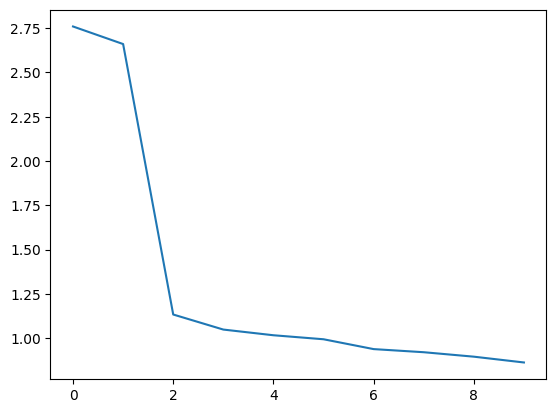

In [37]:
import matplotlib.pyplot as plt
prompt_pool = prompt_pools[0]
all_space = torch.cat([p for p in prompt_pool[0:1]], dim=0)
all_space = prompt_pool[0]
# all_space = torch.mm(all_space.T, all_space)
U, S, Vh = torch.linalg.svd(all_space, full_matrices=False)
print(U.shape, S.shape, Vh.shape)
# Vh = Vh.T
# print(torch.mm(Vh[10:11, :], Vh[20:21, :].T))
# print(S)
topk = int(torch.sum(S > (0.05 * max(S))).cpu().detach().numpy())
print(torch.topk(S, topk)[0])
print(topk)

plt.plot(S.cpu().detach().numpy())


import numpy as np
from scipy.linalg import qr

def qr_null(A, tol=None):
    Q, R, P = qr(A.T, mode='full', pivoting=True)
    tol = np.finfo(R.dtype).eps if tol is None else tol
    rnk = min(A.shape) - np.abs(np.diag(R))[::-1].searchsorted(tol)
    return Q[:, rnk:].conj()

A = np.array([[ 2, 3, 5],
              [-4, 2, 3],
            #   [ 0, 0, 0],
            #   [ 0, 0, 0],
              ]).astype(np.float32)
# A= At.cpu().detach().numpy()
Z = qr_null(A)
t=Z / np.min(abs(Z))
print(t)
# n.shape
n = A[:, :] @ Z[:]
print(n)
# A @ t
# n